## Access Animal Acoustic Tracking Delayed QC data in Parquet

A jupyter notebook to show how to access and plot Animal Acoustic Tracking Delayed QC data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/541d4f15-122a-443d-ab4e-2b5feb08d6a0).

In [1]:
dataset_name = "animal_acoustic_tracking_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 52ms


In [3]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="aodn-cloud-optimised"
dname = f"s3://anonymous@{BUCKET_OPTIMISED_DEFAULT}/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

transmitter_id: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'transmitter_id')
print(list(unique_partition_value)[0:2])  # showing a subset only

['A69-1601-12991', 'A69-1206-1401']
CPU times: user 92.1 ms, sys: 2.63 ms, total: 94.7 ms
Wall time: 93.8 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:444: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:444: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


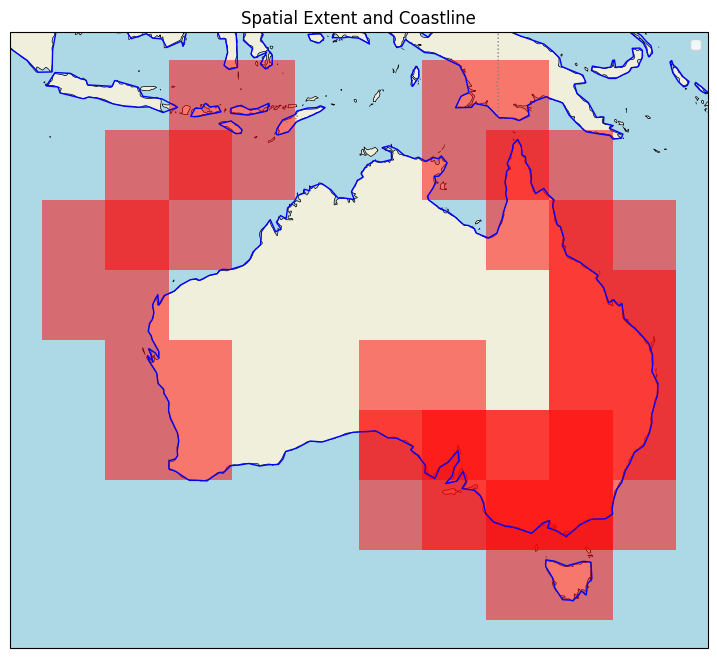

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [9]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2007, 11, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2017, 3, 1, 0, 0, tzinfo=datetime.timezone.utc))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'detection_timestamp': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': '',
  'units': 's',
  'comments': ''},
 'transmitter_id': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'installation_name': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'station_name': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'receiver_name': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'latitude': {'type': 'double',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'longitude': {'type': 'double',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'sensor_value': {'type': 'double',
  'standard_name': '',
  'long_name': '',
  'units': '',
  'comments': ''},
 'sensor_unit': {'type': 'string',
  'standard_name': '',
  'long_name': '',
  'unit

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2009-06-01', date_end='2010-01-01', time_varname='detection_timestamp')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-20, lat_max=-10, lon_min=140, lon_max=143, lat_varname='latitude', lon_varname='longitude')

filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92687 entries, 0 to 92686
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   detection_timestamp       92687 non-null  datetime64[ns]
 1   installation_name         92687 non-null  object        
 2   station_name              92687 non-null  object        
 3   receiver_name             92687 non-null  object        
 4   latitude                  92687 non-null  float64       
 5   longitude                 92687 non-null  float64       
 6   sensor_value              10913 non-null  float64       
 7   sensor_unit               10913 non-null  object        
 8   FDA_QC                    92687 non-null  float32       
 9   Velocity_QC               92687 non-null  float32       
 10  Distance_QC               92687 non-null  float32       
 11  DetectionDistribution_QC  92687 non-null  float32       
 12  DistanceRelease_QC

<Axes: xlabel='longitude', ylabel='latitude'>

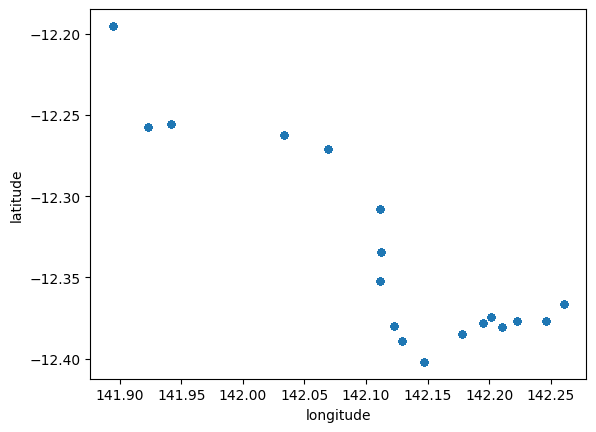

In [13]:
df[df['installation_name']== "Wenlock River"].plot.scatter(x='longitude', y='latitude')

## Create a TIME and scalar/number filter

In [14]:
filter_time = create_time_filter(parquet_ds, date_start='2006-07-12', date_end='2023-02-05', time_varname='detection_timestamp')

expr_1 = pc.field('transmitter_id') == pa.scalar('A69-1105-106')
filter = expr_1 & filter_time

In [15]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36718 entries, 0 to 36717
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   detection_timestamp       36718 non-null  datetime64[ns]
 1   installation_name         36718 non-null  object        
 2   station_name              36718 non-null  object        
 3   receiver_name             36718 non-null  object        
 4   latitude                  36718 non-null  float64       
 5   longitude                 36718 non-null  float64       
 6   sensor_value              36718 non-null  float64       
 7   sensor_unit               36718 non-null  object        
 8   FDA_QC                    36718 non-null  float32       
 9   Velocity_QC               36718 non-null  float32       
 10  Distance_QC               36718 non-null  float32       
 11  DetectionDistribution_QC  36718 non-null  float32       
 12  DistanceRelease_QC

<Axes: xlabel='longitude', ylabel='latitude'>

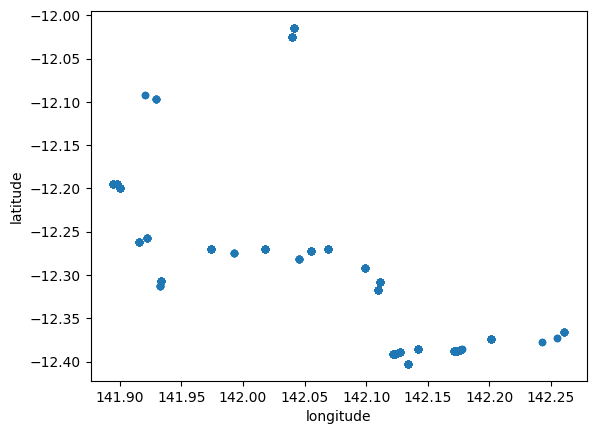

In [16]:
df[df['installation_name']== "Wenlock River"].plot.scatter(x='longitude', y='latitude')